提取空间注意力和时间注意力的功能，并生成相应的热力图
# Spatio-Temporal Attention Extraction for Video Analysis using Temporal Transformer
第1部分 - 导入和类定义：

In [1]:
import os
import av
import torch
import numpy as np
from transformers import TimesformerForVideoClassification, AutoImageProcessor
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from matplotlib.colors import LinearSegmentedColormap

class AttentionExtractor:
    def __init__(self, model_name, device='cuda'):
        self.model = TimesformerForVideoClassification.from_pretrained(model_name)
        self.model.to(device)
        self.device = device
        self.image_processor = AutoImageProcessor.from_pretrained(model_name)

    def extract_attention(self, video_path, num_frames=8):
        container = av.open(video_path)
        frames = [frame.to_image() for frame in container.decode(video=0)]
        sampled_frames = [frames[i] for i in np.linspace(0, len(frames) - 1, num_frames, dtype=int)]
        
        inputs = self.image_processor(sampled_frames, return_tensors="pt").to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs, output_attentions=True)
        
        last_layer_attention = outputs.attentions[-1]
        cls_attention = last_layer_attention.mean(1)[:, 0, 1:]
        
        return cls_attention, sampled_frames, outputs.logits

    def visualize_attention(self, cls_attention, frames, save_path, prediction, true_label):
        num_frames = len(frames)
        attention_map = cls_attention.cpu().numpy().reshape(num_frames, -1)
        
        # Visualize overall attention
        plt.figure(figsize=(15, 5))
        plt.imshow(attention_map, aspect='auto', interpolation='nearest')
        plt.colorbar(label='Attention')
        plt.title(f"Overall Attention (Pred: {prediction}, True: {true_label})")
        plt.xlabel("Spatial Position")
        plt.ylabel("Frame")
        plt.savefig(f"{save_path}_overall_attention.png")
        plt.close()

        # Create a custom colormap
        colors = ["darkblue", "blue", "lightblue", "green", "yellow", "red", "darkred"]
        n_bins = 100
        cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_bins)

        # Visualize attention for each frame
        for i, (frame, att) in enumerate(zip(frames, attention_map)):
            # Original frame
            frame_array = np.array(frame)
            
            # Attention heatmap
            att_resized = att[1:].reshape(int(np.sqrt(len(att)-1)), -1)
            att_resized = Image.fromarray(att_resized).resize(frame.size, Image.BICUBIC)
            att_resized = np.array(att_resized)

            # Normalize attention values
            att_norm = (att_resized - att_resized.min()) / (att_resized.max() - att_resized.min())
            
            # Apply colormap to the attention
            att_color = (cmap(att_norm) * 255).astype(np.uint8)

            # Blend original frame with attention heatmap
            alpha = 0.7
            blended = (1 - alpha) * frame_array + alpha * att_color[:, :, :3]
            blended = np.clip(blended, 0, 255).astype(np.uint8)

            # Create a figure with two subplots side by side
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

            # Display original frame
            ax1.imshow(frame)
            ax1.axis('off')
            ax1.set_title(f"Original Frame {i+1}")

            # Display blended image
            ax2.imshow(blended)
            ax2.axis('off')
            ax2.set_title(f"Attention Heatmap Frame {i+1}")

            # Add colorbar
            fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax2, label='Attention Intensity')

            plt.tight_layout()
            plt.savefig(f"{save_path}_frame_{i+1}_attention.png", dpi=300, bbox_inches='tight')
            plt.close()

def load_labels(label_file):
    labels = {}
    with open(label_file, 'r') as f:
        for line in f:
            video_name, label = line.strip().split()
            labels[video_name] = int(label)
    return labels

def process_videos(config):
    extractor = AttentionExtractor(config['model_name'])
    labels = load_labels(config['label_file'])
    
    all_video_files = [f for f in os.listdir(config['video_directory']) if f.endswith('.mp4')]
    selected_videos = random.sample(all_video_files, min(config['num_videos'], len(all_video_files)))
    
    for video_file in tqdm(selected_videos, desc="Processing videos"):
        video_path = os.path.join(config['video_directory'], video_file)
        cls_attention, frames, logits = extractor.extract_attention(video_path)
        
        prediction = torch.argmax(logits, dim=1).item()
        true_label = labels.get(video_file, labels.get(video_file.split('.')[0], "Unknown"))
        
        save_path = os.path.join(config['output_directory'], video_file.split('.')[0])
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        extractor.visualize_attention(cls_attention, frames, save_path, prediction, true_label)
        
        print(f"Processed {video_file}: Prediction = {prediction}, True Label = {true_label}")
        print(f"Results saved in: {save_path}")

if __name__ == "__main__":
    config = {
        'model_name': 'facebook/timesformer-base-finetuned-k400',
        'video_directory': 'archive/videos_val',
        'output_directory': 'attention_results',
        'label_file': 'archive/kinetics400_val_list_videos.txt',
        'num_videos': 10
    }
    
    process_videos(config)

/home/z/miniconda3/envs/mmxai/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Processing videos:   0%|          | 0/10 [00:00<?, ?it/s]/home/z/miniconda3/envs/mmxai/lib/python3.12/site-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(value)
Processing videos:  10%|█         | 1/10 [00:08<01:14,  8.24s/it]

Processed zrZzxe3mhPQ.mp4: Prediction = 318, True Label = 318
Results saved in: attention_results/zrZzxe3mhPQ


Processing videos:  20%|██        | 2/10 [00:16<01:06,  8.25s/it]

Processed xDuPykZ4aHQ.mp4: Prediction = 253, True Label = 253
Results saved in: attention_results/xDuPykZ4aHQ


Processing videos:  30%|███       | 3/10 [00:25<01:00,  8.58s/it]

Processed V6LJJR6OBRI.mp4: Prediction = 336, True Label = 336
Results saved in: attention_results/V6LJJR6OBRI


Processing videos:  40%|████      | 4/10 [00:33<00:50,  8.34s/it]

Processed DE9WqtvwImg.mp4: Prediction = 151, True Label = 151
Results saved in: attention_results/DE9WqtvwImg


Processing videos:  50%|█████     | 5/10 [00:42<00:42,  8.54s/it]

Processed d7E4VMP8ZRA.mp4: Prediction = 286, True Label = 286
Results saved in: attention_results/d7E4VMP8ZRA


Processing videos:  60%|██████    | 6/10 [00:50<00:33,  8.38s/it]

Processed _wfFdIqtHLg.mp4: Prediction = 364, True Label = 364
Results saved in: attention_results/_wfFdIqtHLg


Processing videos:  70%|███████   | 7/10 [00:59<00:25,  8.50s/it]

Processed 0_obbLl1Zyg.mp4: Prediction = 376, True Label = 376
Results saved in: attention_results/0_obbLl1Zyg


Processing videos:  80%|████████  | 8/10 [01:07<00:16,  8.49s/it]

Processed WwJkHR_-Vao.mp4: Prediction = 337, True Label = 337
Results saved in: attention_results/WwJkHR_-Vao


Processing videos:  90%|█████████ | 9/10 [01:16<00:08,  8.47s/it]

Processed c_orAN_W-kU.mp4: Prediction = 262, True Label = 262
Results saved in: attention_results/c_orAN_W-kU


Processing videos: 100%|██████████| 10/10 [01:24<00:00,  8.42s/it]

Processed 9E1KtFdU2g0.mp4: Prediction = 174, True Label = 208
Results saved in: attention_results/9E1KtFdU2g0


Processing videos:  10%|█         | 1/10 [00:10<01:30, 10.00s/it]

Processed awwbXD7N5W0.mp4: Prediction = 46, True Label = 46
Results saved in: attention_results/awwbXD7N5W0


Processing videos:  20%|██        | 2/10 [00:19<01:19,  9.96s/it]

Processed bKeiaJvBGws.mp4: Prediction = 329, True Label = 329
Results saved in: attention_results/bKeiaJvBGws


Processing videos:  30%|███       | 3/10 [00:30<01:13, 10.43s/it]

Processed 2-M5TagOHMw.mp4: Prediction = 53, True Label = 54
Results saved in: attention_results/2-M5TagOHMw


Processing videos:  40%|████      | 4/10 [00:41<01:02, 10.36s/it]

Processed plJH3_MfYzg.mp4: Prediction = 103, True Label = 103
Results saved in: attention_results/plJH3_MfYzg


Processing videos:  40%|████      | 4/10 [00:46<01:09, 11.61s/it]


KeyboardInterrupt: 

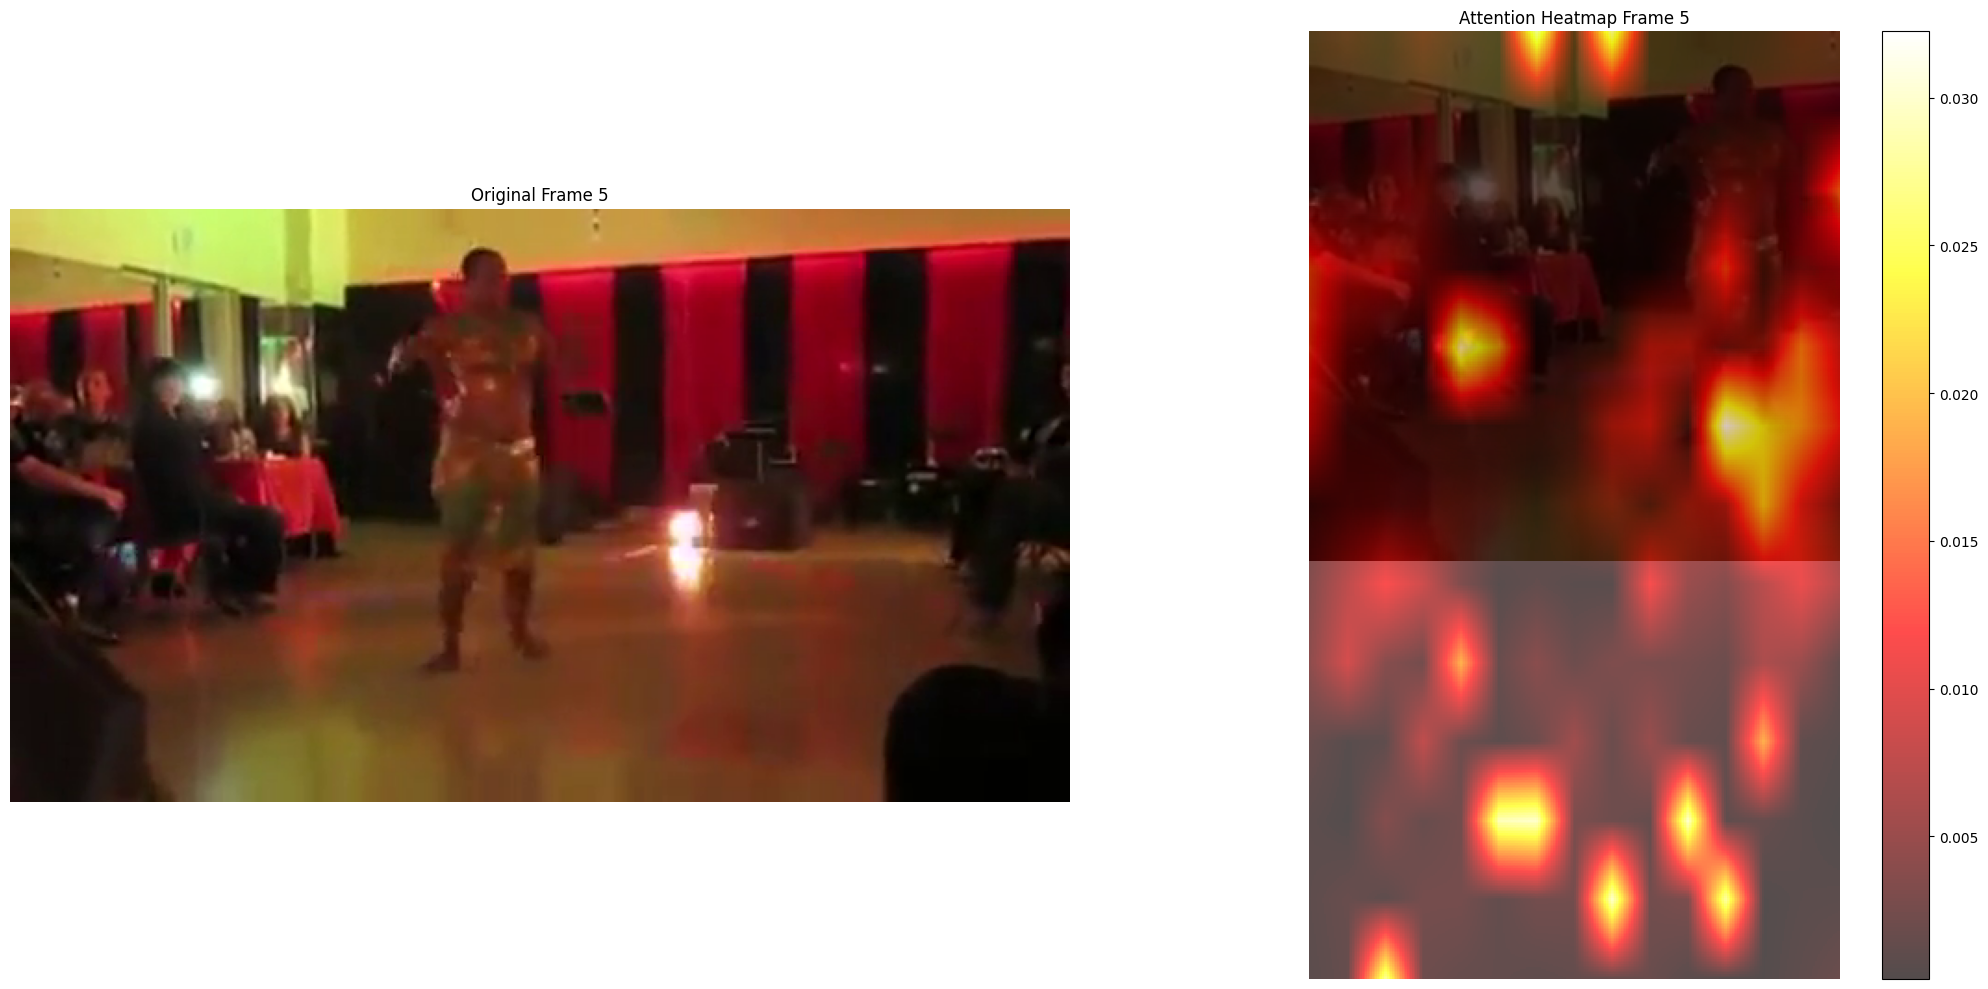

In [18]:
import os
import av
import torch
import numpy as np
from transformers import TimesformerForVideoClassification, AutoImageProcessor
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from scipy.ndimage import zoom

class AttentionExtractor:
    def __init__(self, model_name, device='cuda'):
        self.model = TimesformerForVideoClassification.from_pretrained(model_name)
        self.model.to(device)
        self.device = device
        self.image_processor = AutoImageProcessor.from_pretrained(model_name)

    def extract_attention(self, video_path, num_frames=8):
        container = av.open(video_path)
        frames = [frame.to_image() for frame in container.decode(video=0)]
        sampled_frames = [frames[i] for i in np.linspace(0, len(frames) - 1, num_frames, dtype=int)]
        
        inputs = self.image_processor(sampled_frames, return_tensors="pt").to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs, output_attentions=True)
        
        last_layer_attention = outputs.attentions[-1]
        cls_attention = last_layer_attention.mean(1)[:, 0, 1:]
        
        return cls_attention, sampled_frames, outputs.logits

    def visualize_attention(self, cls_attention, frames, save_path, prediction, true_label):
        num_frames = len(frames)
        attention_map = cls_attention.cpu().numpy().reshape(num_frames, -1)
        
        # Visualize overall attention
        plt.figure(figsize=(15, 5))
        plt.imshow(attention_map, aspect='auto', interpolation='nearest')
        plt.colorbar(label='Attention')
        plt.title(f"Overall Attention (Pred: {prediction}, True: {true_label})")
        plt.xlabel("Spatial Position")
        plt.ylabel("Frame")
        plt.savefig(f"{save_path}_overall_attention.png")
        plt.close()

        # Visualize attention for each frame
        for i, (frame, att) in enumerate(zip(frames, attention_map)):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
            
            # Original frame
            ax1.imshow(frame)
            ax1.axis('off')
            ax1.set_title(f"Original Frame {i+1}")
            
            # Attention heatmap
            h, w = frame.size
            att_resized = att[1:].reshape(int(np.sqrt(len(att)-1)), -1)
            
            # Use scipy.ndimage.zoom for smoother interpolation
            zoom_h, zoom_w = h / att_resized.shape[0], w / att_resized.shape[1]
            att_resized = zoom(att_resized, (zoom_h, zoom_w), order=1)
            
            ax2.imshow(frame)
            im = ax2.imshow(att_resized, cmap='hot', alpha=0.7, interpolation='nearest', extent=(0, w, h, 0))
            ax2.axis('off')
            ax2.set_title(f"Attention Heatmap Frame {i+1}")
            
            plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
            plt.tight_layout()
            plt.savefig(f"{save_path}_frame_{i+1}_attention.png", dpi=300, bbox_inches='tight')
            plt.close()

def load_labels(label_file):
    labels = {}
    with open(label_file, 'r') as f:
        for line in f:
            video_name, label = line.strip().split()
            labels[video_name] = int(label)
    return labels

def process_videos(config):
    extractor = AttentionExtractor(config['model_name'])
    labels = load_labels(config['label_file'])
    
    all_video_files = [f for f in os.listdir(config['video_directory']) if f.endswith('.mp4')]
    selected_videos = random.sample(all_video_files, min(config['num_videos'], len(all_video_files)))
    
    for video_file in tqdm(selected_videos, desc="Processing videos"):
        video_path = os.path.join(config['video_directory'], video_file)
        cls_attention, frames, logits = extractor.extract_attention(video_path)
        
        prediction = torch.argmax(logits, dim=1).item()
        true_label = labels.get(video_file, labels.get(video_file.split('.')[0], "Unknown"))
        
        save_path = os.path.join(config['output_directory'], video_file.split('.')[0])
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        extractor.visualize_attention(cls_attention, frames, save_path, prediction, true_label)
        
        print(f"Processed {video_file}: Prediction = {prediction}, True Label = {true_label}")
        print(f"Results saved in: {save_path}")

if __name__ == "__main__":
    config = {
        'model_name': 'facebook/timesformer-base-finetuned-k400',
        'video_directory': 'archive/videos_val',
        'output_directory': 'attention_results',
        'label_file': 'archive/kinetics400_val_list_videos.txt',
        'num_videos': 10
    }
    
    process_videos(config)

第2部分 - 辅助函数：

第3部分 - 主程序：

这个版本已经可以实现从timesformer 提取 self attention

In [2]:
import os
import av
import torch
import numpy as np
from transformers import TimesformerForVideoClassification, AutoImageProcessor
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

class AttentionExtractor:
    def __init__(self, model_name, device='cuda'):
        self.model = TimesformerForVideoClassification.from_pretrained(model_name)
        self.model.to(device)
        self.device = device
        self.image_processor = AutoImageProcessor.from_pretrained(model_name)

    def print_model_structure(self):
        print(self.model)

    def extract_attention(self, video_path, num_frames=8):
        container = av.open(video_path)
        frames = [frame.to_image() for frame in container.decode(video=0)]
        sampled_frames = [frames[i] for i in np.linspace(0, len(frames) - 1, num_frames, dtype=int)]
        
        inputs = self.image_processor(sampled_frames, return_tensors="pt").to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs, output_attentions=True)
        
        # Extract attention from the last layer
        last_layer_attention = outputs.attentions[-1]
        
        # Extract spatial attention (average over heads)
        spatial_attention = last_layer_attention.mean(1)
        
        # Extract temporal attention (use the attention of the CLS token to all frames)
        temporal_attention = spatial_attention[:, 0, 1:num_frames+1]
        
        return spatial_attention, temporal_attention, sampled_frames, outputs.logits

    def visualize_attention(self, spatial_attention, temporal_attention, frames, save_path, prediction, true_label):
        num_frames = len(frames)
        
        # Visualize spatial attention
        for i, frame in enumerate(frames):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
            
            # Original frame
            ax1.imshow(frame)
            ax1.axis('off')
            ax1.set_title(f"Original Frame {i+1}")
            
            # Spatial attention heatmap
            att_map = spatial_attention[0, i+1, 1:].reshape(int(np.sqrt(spatial_attention.shape[2]-1)), -1).cpu().numpy()
            att_resized = Image.fromarray(att_map).resize(frame.size, Image.BICUBIC)
            att_resized = np.array(att_resized)
            
            # Normalize attention values
            att_norm = (att_resized - att_resized.min()) / (att_resized.max() - att_resized.min())
            
            # Convert frame to numpy array if it's not already
            frame_array = np.array(frame)
            
            # Create a heatmap overlay
            heatmap = plt.cm.hot(att_norm)
            heatmap = heatmap[..., :3]  # Remove alpha channel
            
            # Blend original frame with heatmap
            blend = 0.7 * frame_array / 255 + 0.3 * heatmap
            blend = np.clip(blend, 0, 1)
            
            # Display blended image
            im = ax2.imshow(blend)
            ax2.axis('off')
            ax2.set_title(f"Spatial Attention Heatmap Frame {i+1}")
            
            plt.colorbar(im, ax=ax2, label='Attention Intensity')
            plt.tight_layout()
            plt.savefig(f"{save_path}_frame_{i+1}_spatial_attention.png", dpi=300, bbox_inches='tight')
            plt.close()
        
        # Visualize temporal attention
        temporal_att = temporal_attention[0].cpu().numpy()
        plt.figure(figsize=(15, 5))
        plt.imshow(temporal_att.reshape(1, -1), aspect='auto', interpolation='nearest')
        plt.colorbar(label='Attention')
        plt.title(f"Temporal Attention (Pred: {prediction}, True: {true_label})")
        plt.xlabel("Frame")
        plt.ylabel("CLS Token Attention")
        plt.savefig(f"{save_path}_temporal_attention.png", dpi=300, bbox_inches='tight')
        plt.close()

        # Print attention shapes for debugging
        print(f"Spatial attention shape: {spatial_attention.shape}")
        print(f"Temporal attention shape: {temporal_attention.shape}")

def load_labels(label_file):
    labels = {}
    with open(label_file, 'r') as f:
        for line in f:
            video_name, label = line.strip().split()
            labels[video_name] = int(label)
    return labels

def process_videos(config):
    extractor = AttentionExtractor(config['model_name'])
    
    if config['print_model']:
        extractor.print_model_structure()
    
    labels = load_labels(config['label_file'])
    
    all_video_files = [f for f in os.listdir(config['video_directory']) if f.endswith('.mp4')]
    selected_videos = random.sample(all_video_files, min(config['num_videos'], len(all_video_files)))
    
    for video_file in tqdm(selected_videos, desc="Processing videos"):
        video_path = os.path.join(config['video_directory'], video_file)
        spatial_attention, temporal_attention, frames, logits = extractor.extract_attention(video_path)
        
        prediction = torch.argmax(logits, dim=1).item()
        true_label = labels.get(video_file, labels.get(video_file.split('.')[0], "Unknown"))
        
        save_path = os.path.join(config['output_directory'], video_file.split('.')[0])
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        extractor.visualize_attention(spatial_attention, temporal_attention, frames, save_path, prediction, true_label)
        
        print(f"Processed {video_file}: Prediction = {prediction}, True Label = {true_label}")
        print(f"Results saved in: {save_path}")

if __name__ == "__main__":
    config = {
        'model_name': 'facebook/timesformer-base-finetuned-k400',
        'video_directory': 'archive/videos_val',
        'output_directory': 'attention_results',
        'label_file': 'archive/kinetics400_val_list_videos.txt',
        'num_videos': 10,
        'print_model': True  # 设置为 True 以打印模型结构
    }
    
    process_videos(config)

TimesformerForVideoClassification(
  (timesformer): TimesformerModel(
    (embeddings): TimesformerEmbeddings(
      (patch_embeddings): TimesformerPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (time_drop): Dropout(p=0.0, inplace=False)
    )
    (encoder): TimesformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x TimesformerLayer(
          (drop_path): Identity()
          (attention): TimeSformerAttention(
            (attention): TimesformerSelfAttention(
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
            )
            (output): TimesformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): TimesformerIntermediate(
            (dense

Processing videos:  10%|█         | 1/10 [00:10<01:32, 10.33s/it]

Spatial attention shape: torch.Size([8, 197, 197])
Temporal attention shape: torch.Size([8, 8])
Processed fM3BD1kL_-g.mp4: Prediction = 123, True Label = 212
Results saved in: attention_results/fM3BD1kL_-g


Processing videos:  20%|██        | 2/10 [00:19<01:17,  9.65s/it]

Spatial attention shape: torch.Size([8, 197, 197])
Temporal attention shape: torch.Size([8, 8])
Processed GpI8DSsvwXI.mp4: Prediction = 383, True Label = 383
Results saved in: attention_results/GpI8DSsvwXI


Processing videos:  30%|███       | 3/10 [00:28<01:06,  9.44s/it]

Spatial attention shape: torch.Size([8, 197, 197])
Temporal attention shape: torch.Size([8, 8])
Processed TJpmrZ7DrEc.mp4: Prediction = 155, True Label = 155
Results saved in: attention_results/TJpmrZ7DrEc


Processing videos:  40%|████      | 4/10 [00:40<01:01, 10.19s/it]

Spatial attention shape: torch.Size([8, 197, 197])
Temporal attention shape: torch.Size([8, 8])
Processed PCZp6p8PCBA.mp4: Prediction = 147, True Label = 20
Results saved in: attention_results/PCZp6p8PCBA


Processing videos:  50%|█████     | 5/10 [00:50<00:51, 10.24s/it]

Spatial attention shape: torch.Size([8, 197, 197])
Temporal attention shape: torch.Size([8, 8])
Processed oGLY8G334yU.mp4: Prediction = 55, True Label = 55
Results saved in: attention_results/oGLY8G334yU


Processing videos:  60%|██████    | 6/10 [01:00<00:40, 10.22s/it]

Spatial attention shape: torch.Size([8, 197, 197])
Temporal attention shape: torch.Size([8, 8])
Processed EDLiHlfAyQ8.mp4: Prediction = 138, True Label = 138
Results saved in: attention_results/EDLiHlfAyQ8


Processing videos:  70%|███████   | 7/10 [01:10<00:30, 10.27s/it]

Spatial attention shape: torch.Size([8, 197, 197])
Temporal attention shape: torch.Size([8, 8])
Processed lskWtP3jyFc.mp4: Prediction = 78, True Label = 78
Results saved in: attention_results/lskWtP3jyFc


Processing videos:  80%|████████  | 8/10 [01:20<00:20, 10.10s/it]

Spatial attention shape: torch.Size([8, 197, 197])
Temporal attention shape: torch.Size([8, 8])
Processed QiCIPiTh4lo.mp4: Prediction = 74, True Label = 361
Results saved in: attention_results/QiCIPiTh4lo


Processing videos:  90%|█████████ | 9/10 [01:30<00:09,  9.97s/it]

Spatial attention shape: torch.Size([8, 197, 197])
Temporal attention shape: torch.Size([8, 8])
Processed CrXRUmAasfU.mp4: Prediction = 268, True Label = 268
Results saved in: attention_results/CrXRUmAasfU


Processing videos: 100%|██████████| 10/10 [01:40<00:00, 10.03s/it]

Spatial attention shape: torch.Size([8, 197, 197])
Temporal attention shape: torch.Size([8, 8])
Processed 9J6ZMmY6PS4.mp4: Prediction = 109, True Label = 109
Results saved in: attention_results/9J6ZMmY6PS4


目标是为了更好的平滑显示heatmap，输出视频

In [5]:
import os
import av
import torch
import numpy as np
from transformers import TimesformerForVideoClassification, AutoImageProcessor
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import cv2

class AttentionExtractor:
    def __init__(self, model_name, device='cuda'):
        self.model = TimesformerForVideoClassification.from_pretrained(model_name)
        self.model.to(device)
        self.device = device
        self.image_processor = AutoImageProcessor.from_pretrained(model_name)

    def extract_attention(self, frames):
        inputs = self.image_processor(frames, return_tensors="pt").to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs, output_attentions=True)
        
        last_layer_attention = outputs.attentions[-1]
        spatial_attention = last_layer_attention.mean(1)
        
        return spatial_attention

    def apply_attention_heatmap(self, frame, attention):
        att_map = attention[1:].reshape(int(np.sqrt(attention.shape[0]-1)), -1).cpu().numpy()
        att_resized = cv2.resize(att_map, (frame.shape[1], frame.shape[0]))
        
        att_norm = (att_resized - att_resized.min()) / (att_resized.max() - att_resized.min())
        
        heatmap = cv2.applyColorMap(np.uint8(255 * att_norm), cv2.COLORMAP_JET)
        
        blend = cv2.addWeighted(frame, 0.7, heatmap, 0.3, 0)
        
        return blend

def process_video(video_path, output_path, extractor):
    container = av.open(video_path)
    video_stream = container.streams.video[0]
    
    fps = video_stream.average_rate
    width = video_stream.width
    height = video_stream.height

    output = av.open(output_path, mode='w')
    output_stream = output.add_stream('h264', rate=fps)
    output_stream.width = width
    output_stream.height = height
    output_stream.pix_fmt = 'yuv420p'

    frames = []
    attention_buffer = []
    for frame in tqdm(container.decode(video=0), desc="Processing frames"):
        frames.append(frame.to_image())
        if len(frames) == 8:
            spatial_attention = extractor.extract_attention(frames)
            attention_buffer.extend(spatial_attention[0, 1:])  # 存储每一帧的attention
            
            # 处理并输出最早的帧
            img_array = np.array(frames[0])
            attention = attention_buffer.pop(0)
            heatmap_frame = extractor.apply_attention_heatmap(img_array, attention)
            
            out_frame = av.VideoFrame.from_ndarray(heatmap_frame, format='rgb24')
            packet = output_stream.encode(out_frame)
            output.mux(packet)
            
            frames.pop(0)

    # 处理剩余的帧
    while frames:
        if len(frames) < 8:
            padding = [frames[-1]] * (8 - len(frames))
            spatial_attention = extractor.extract_attention(frames + padding)
            attention_buffer.extend(spatial_attention[0, 1:len(frames)+1])
        
        img_array = np.array(frames[0])
        attention = attention_buffer.pop(0)
        heatmap_frame = extractor.apply_attention_heatmap(img_array, attention)
        
        out_frame = av.VideoFrame.from_ndarray(heatmap_frame, format='rgb24')
        packet = output_stream.encode(out_frame)
        output.mux(packet)
        
        frames.pop(0)

    # 刷新输出流
    packet = output_stream.encode(None)
    output.mux(packet)

    # 关闭输出文件
    output.close()

def process_videos(config):
    extractor = AttentionExtractor(config['model_name'])
    
    all_video_files = [f for f in os.listdir(config['video_directory']) if f.endswith('.mp4')]
    selected_videos = random.sample(all_video_files, min(config['num_videos'], len(all_video_files)))
    
    for video_file in tqdm(selected_videos, desc="Processing videos"):
        video_path = os.path.join(config['video_directory'], video_file)
        output_path = os.path.join(config['output_directory'], f"{video_file.split('.')[0]}_heatmap.mp4")
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        process_video(video_path, output_path, extractor)
        
        print(f"Processed {video_file}")
        print(f"Results saved in: {output_path}")

if __name__ == "__main__":
    config = {
        'model_name': 'facebook/timesformer-base-finetuned-k400',
        'video_directory': 'archive/videos_val',
        'output_directory': 'attention_results_v',
        'num_videos': 10
    }
    
    process_videos(config)

Processing frames: 300it [00:52,  5.69it/s]0:00<?, ?it/s]
Processing videos:  10%|█         | 1/10 [00:54<08:08, 54.25s/it]

Processed na9OVxD-EVY.mp4
Results saved in: attention_results_v/na9OVxD-EVY_heatmap.mp4


Processing frames: 300it [00:53,  5.56it/s]
Processing videos:  20%|██        | 2/10 [01:49<07:18, 54.87s/it]

Processed y_-ivQSPV0Q.mp4
Results saved in: attention_results_v/y_-ivQSPV0Q_heatmap.mp4


Processing frames: 300it [00:55,  5.44it/s]
Processing videos:  30%|███       | 3/10 [02:46<06:29, 55.64s/it]

Processed Ud-INZAw5Ik.mp4
Results saved in: attention_results_v/Ud-INZAw5Ik_heatmap.mp4


Processing frames: 148it [00:26,  5.64it/s]
Processing videos:  40%|████      | 4/10 [03:13<04:27, 44.58s/it]

Processed qaEwI-jJ0CI.mp4
Results saved in: attention_results_v/qaEwI-jJ0CI_heatmap.mp4


Processing frames: 300it [00:53,  5.57it/s]
Processing videos:  50%|█████     | 5/10 [04:09<04:02, 48.47s/it]

Processed SOX5yA1l24A.mp4
Results saved in: attention_results_v/SOX5yA1l24A_heatmap.mp4


Processing frames: 300it [00:54,  5.54it/s]
Processing videos:  60%|██████    | 6/10 [05:04<03:23, 50.88s/it]

Processed z-6CXisVoHw.mp4
Results saved in: attention_results_v/z-6CXisVoHw_heatmap.mp4


Processing frames: 295it [00:52,  5.61it/s]
Processing videos:  60%|██████    | 6/10 [05:57<03:58, 59.54s/it]


ValueError: Unable to create tensor, you should probably activate padding with 'padding=True' to have batched tensors with the same length.

select 1

In [12]:
import os
import av
import torch
import numpy as np
from transformers import TimesformerForVideoClassification, AutoImageProcessor
from PIL import Image
import cv2
from tqdm import tqdm

class AttentionExtractor:
    def __init__(self, model_name, device='cuda'):
        self.model = TimesformerForVideoClassification.from_pretrained(model_name)
        self.model.to(device)
        self.device = device
        self.image_processor = AutoImageProcessor.from_pretrained(model_name)

    def extract_attention(self, frames):
        inputs = self.image_processor(frames, return_tensors="pt").to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs, output_attentions=True)
        
        last_layer_attention = outputs.attentions[-1]
        spatial_attention = last_layer_attention.mean(1)
        
        return spatial_attention

    def apply_attention_heatmap(self, frame, attention):
        att_map = attention[1:].reshape(int(np.sqrt(attention.shape[0]-1)), -1).cpu().numpy()
        att_resized = cv2.resize(att_map, (frame.shape[1], frame.shape[0]))
        
        att_norm = (att_resized - att_resized.min()) / (att_resized.max() - att_resized.min())
        
        heatmap = cv2.applyColorMap(np.uint8(255 * att_norm), cv2.COLORMAP_JET)
        
        blend = cv2.addWeighted(frame, 0.7, heatmap, 0.3, 0)
        
        return blend

def process_video(video_path, output_path, extractor):
    container = av.open(video_path)
    video_stream = container.streams.video[0]
    
    fps = video_stream.average_rate
    width = video_stream.width
    height = video_stream.height

    output = av.open(output_path, mode='w')
    output_stream = output.add_stream('h264', rate=fps)
    output_stream.width = width
    output_stream.height = height
    output_stream.pix_fmt = 'yuv420p'

    frames = []
    attention_buffer = []
    for frame in tqdm(container.decode(video=0), desc="Processing frames"):
        frames.append(frame.to_image())
        if len(frames) == 8:
            spatial_attention = extractor.extract_attention(frames)
            attention_buffer.extend(spatial_attention[0, 1:])  # 存储每一帧的attention
            
            # 处理并输出最早的帧
            img_array = np.array(frames[0])
            attention = attention_buffer.pop(0)
            heatmap_frame = extractor.apply_attention_heatmap(img_array, attention)
            
            out_frame = av.VideoFrame.from_ndarray(heatmap_frame, format='rgb24')
            packet = output_stream.encode(out_frame)
            output.mux(packet)
            
            frames.pop(0)

    # 处理剩余的帧
    while frames:
        if len(frames) < 8:
            padding = [frames[-1]] * (8 - len(frames))
            spatial_attention = extractor.extract_attention(frames + padding)
            attention_buffer.extend(spatial_attention[0, 1:len(frames)+1])
        
        img_array = np.array(frames[0])
        attention = attention_buffer.pop(0)
        heatmap_frame = extractor.apply_attention_heatmap(img_array, attention)
        
        out_frame = av.VideoFrame.from_ndarray(heatmap_frame, format='rgb24')
        packet = output_stream.encode(out_frame)
        output.mux(packet)
        
        frames.pop(0)

    # 刷新输出流
    packet = output_stream.encode(None)
    output.mux(packet)

    # 关闭输出文件
    output.close()

def process_specific_video(config):
    extractor = AttentionExtractor(config['model_name'])
    
    video_file = "HNPzn5fY0H0.mp4"
    video_path = os.path.join(config['video_directory'], video_file)
    output_path = os.path.join(config['output_directory'], f"{video_file.split('.')[0]}_heatmap.mp4")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    process_video(video_path, output_path, extractor)
    
    print(f"Processed {video_file}")
    print(f"Results saved in: {output_path}")

if __name__ == "__main__":
    config = {
        'model_name': 'facebook/timesformer-base-finetuned-k400',
        'video_directory': 'archive/videos_val',
        'output_directory': 'attention_results_sample',
    }
    
    process_specific_video(config)

Processing frames: 300it [00:46,  6.47it/s]


Processed HNPzn5fY0H0.mp4
Results saved in: attention_results_sample/HNPzn5fY0H0_heatmap.mp4


Make frames smooth

In [7]:
import os
import av
import torch
import numpy as np
from transformers import TimesformerForVideoClassification, AutoImageProcessor
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import cv2

class AttentionExtractor:
    def __init__(self, model_name, device='cuda'):
        self.model = TimesformerForVideoClassification.from_pretrained(model_name)
        self.model.to(device)
        self.device = device
        self.image_processor = AutoImageProcessor.from_pretrained(model_name)

    def extract_attention(self, frames):
        inputs = self.image_processor(frames, return_tensors="pt").to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs, output_attentions=True)
        
        last_layer_attention = outputs.attentions[-1]
        spatial_attention = last_layer_attention.mean(1)
        
        return spatial_attention.cpu().numpy()

    def apply_attention_heatmap(self, frame, attention):
        att_map = attention[1:].reshape(int(np.sqrt(attention.shape[0]-1)), -1)
        att_resized = cv2.resize(att_map, (frame.shape[1], frame.shape[0]))
        
        # 减小高斯模糊的kernel大小
        att_smoothed = cv2.GaussianBlur(att_resized, (7, 7), 0)
        
        # 使用自适应阈值
        att_threshold = np.percentile(att_smoothed, 70)
        att_smoothed[att_smoothed < att_threshold] = 0
        
        att_norm = (att_smoothed - att_smoothed.min()) / (att_smoothed.max() - att_smoothed.min() + 1e-8)
        
        heatmap = cv2.applyColorMap(np.uint8(255 * att_norm), cv2.COLORMAP_JET)
        
        blend = cv2.addWeighted(frame, 0.7, heatmap, 0.3, 0)
        
        return blend

def process_video(video_path, output_path, extractor):
    container = av.open(video_path)
    video_stream = container.streams.video[0]
    
    fps = video_stream.average_rate
    width = video_stream.width
    height = video_stream.height

    output = av.open(output_path, mode='w')
    output_stream = output.add_stream('h264', rate=fps)
    output_stream.width = width
    output_stream.height = height
    output_stream.pix_fmt = 'yuv420p'

    frames = []
    attention_buffer = []
    temporal_smoothing_window = 3  # 减小时间平滑窗口

    for frame in tqdm(container.decode(video=0), desc="Processing frames"):
        frames.append(frame.to_image())
        if len(frames) == 8:
            spatial_attention = extractor.extract_attention(frames)
            
            # 处理每一帧
            for i in range(8):
                attention = spatial_attention[0, i+1]
                attention_buffer.append(attention)
                
                if len(attention_buffer) >= temporal_smoothing_window:
                    smoothed_attention = np.mean(attention_buffer[-temporal_smoothing_window:], axis=0)
                    
                    img_array = np.array(frames[i])
                    heatmap_frame = extractor.apply_attention_heatmap(img_array, smoothed_attention)
                    
                    out_frame = av.VideoFrame.from_ndarray(heatmap_frame, format='rgb24')
                    packet = output_stream.encode(out_frame)
                    output.mux(packet)
            
            frames = frames[7:]  # 保留最后一帧用于下一批次

    # 处理剩余的帧
    while frames:
        if len(frames) < 8:
            padding = [frames[-1]] * (8 - len(frames))
            spatial_attention = extractor.extract_attention(frames + padding)
            
            for i in range(len(frames)):
                attention = spatial_attention[0, i+1]
                attention_buffer.append(attention)
                
                smoothed_attention = np.mean(attention_buffer[-temporal_smoothing_window:], axis=0)
                
                img_array = np.array(frames[i])
                heatmap_frame = extractor.apply_attention_heatmap(img_array, smoothed_attention)
                
                out_frame = av.VideoFrame.from_ndarray(heatmap_frame, format='rgb24')
                packet = output_stream.encode(out_frame)
                output.mux(packet)
        
        frames = []

    # 刷新输出流
    packet = output_stream.encode(None)
    output.mux(packet)

    # 关闭输出文件
    output.close()

def process_videos(config):
    extractor = AttentionExtractor(config['model_name'])
    
    all_video_files = [f for f in os.listdir(config['video_directory']) if f.endswith('.mp4')]
    selected_videos = random.sample(all_video_files, min(config['num_videos'], len(all_video_files)))
    
    for video_file in tqdm(selected_videos, desc="Processing videos"):
        video_path = os.path.join(config['video_directory'], video_file)
        output_path = os.path.join(config['output_directory'], f"{video_file.split('.')[0]}_heatmap.mp4")
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        process_video(video_path, output_path, extractor)
        
        print(f"Processed {video_file}")
        print(f"Results saved in: {output_path}")

if __name__ == "__main__":
    config = {
        'model_name': 'facebook/timesformer-base-finetuned-k400',
        'video_directory': 'archive/videos_val',
        'output_directory': 'attention_results_vs',
        'num_videos': 10
    }
    
    process_videos(config)

Processing frames: 300it [00:09, 31.15it/s]0:00<?, ?it/s]
Processing videos:  10%|█         | 1/10 [00:09<01:29,  9.94s/it]

Processed 0rnJX3pe3nY.mp4
Results saved in: attention_results_vs/0rnJX3pe3nY_heatmap.mp4


Processing frames: 299it [00:08, 33.90it/s]
Processing videos:  20%|██        | 2/10 [00:19<01:15,  9.45s/it]

Processed 9cbRsJVneGE.mp4
Results saved in: attention_results_vs/9cbRsJVneGE_heatmap.mp4


Processing frames: 300it [00:09, 31.61it/s]
Processing videos:  30%|███       | 3/10 [00:28<01:07,  9.60s/it]

Processed K1C_jI8z1F8.mp4
Results saved in: attention_results_vs/K1C_jI8z1F8_heatmap.mp4


Processing frames: 300it [00:09, 32.93it/s]
Processing videos:  40%|████      | 4/10 [00:38<00:57,  9.53s/it]

Processed mCJl0fJF7ic.mp4
Results saved in: attention_results_vs/mCJl0fJF7ic_heatmap.mp4


Processing frames: 300it [00:09, 33.00it/s]
Processing videos:  50%|█████     | 5/10 [00:47<00:47,  9.48s/it]

Processed HNPzn5fY0H0.mp4
Results saved in: attention_results_vs/HNPzn5fY0H0_heatmap.mp4


Processing frames: 299it [00:09, 33.16it/s]
Processing videos:  60%|██████    | 6/10 [00:57<00:37,  9.44s/it]

Processed BPdhR_xx4m4.mp4
Results saved in: attention_results_vs/BPdhR_xx4m4_heatmap.mp4


Processing frames: 300it [00:09, 32.59it/s]
Processing videos:  70%|███████   | 7/10 [01:06<00:28,  9.48s/it]

Processed ZlF61ic42wc.mp4
Results saved in: attention_results_vs/ZlF61ic42wc_heatmap.mp4


Processing frames: 300it [00:09, 33.25it/s]
Processing videos:  80%|████████  | 8/10 [01:15<00:18,  9.43s/it]

Processed JdWRc7gtJn8.mp4
Results saved in: attention_results_vs/JdWRc7gtJn8_heatmap.mp4


Processing frames: 300it [00:09, 30.40it/s]
Processing videos:  90%|█████████ | 9/10 [01:26<00:09,  9.67s/it]

Processed ZgoIEs8SuYE.mp4
Results saved in: attention_results_vs/ZgoIEs8SuYE_heatmap.mp4


Processing frames: 302it [00:10, 29.82it/s]
Processing videos: 100%|██████████| 10/10 [01:36<00:00,  9.65s/it]

Processed 0tlSAcpc7_o.mp4
Results saved in: attention_results_vs/0tlSAcpc7_o_heatmap.mp4


In [8]:
from transformers import TimesformerForVideoClassification

model = TimesformerForVideoClassification.from_pretrained('facebook/timesformer-base-finetuned-k400')
print(model)

TimesformerForVideoClassification(
  (timesformer): TimesformerModel(
    (embeddings): TimesformerEmbeddings(
      (patch_embeddings): TimesformerPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (time_drop): Dropout(p=0.0, inplace=False)
    )
    (encoder): TimesformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x TimesformerLayer(
          (drop_path): Identity()
          (attention): TimeSformerAttention(
            (attention): TimesformerSelfAttention(
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
            )
            (output): TimesformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): TimesformerIntermediate(
            (dense

In [11]:
from transformers import TimesformerForVideoClassification
from torchinfo import summary

model = TimesformerForVideoClassification.from_pretrained('facebook/timesformer-base-finetuned-k400')
summary(model, input_size=(1, 8, 3, 224, 224))  # (batch_size, num_frames, channels, height, width)

/home/z/miniconda3/envs/mmxai/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Layer (type:depth-idx)                                            Output Shape              Param #
TimesformerForVideoClassification                                 [1, 400]                  --
├─TimesformerModel: 1-1                                           [1, 1569, 768]            --
│    └─TimesformerEmbeddings: 2-1                                 [1, 1569, 768]            158,208
│    │    └─TimesformerPatchEmbeddings: 3-1                       [8, 196, 768]             590,592
│    │    └─Dropout: 3-2                                          [8, 197, 768]             --
│    │    └─Dropout: 3-3                                          [196, 8, 768]             --
│    └─TimesformerEncoder: 2-2                                    [1, 1569, 768]            --
│    │    └─ModuleList: 3-4                                       --                        120,508,416
│    └─LayerNorm: 2-3                                             [1, 1569, 768]            1,536
├─Linear: 1-2          

In [10]:
!pip install torchinfo

Save results json, png

In [16]:
import os
import av
import torch
import numpy as np
from transformers import TimesformerForVideoClassification, AutoImageProcessor
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import cv2
import json

class AttentionExtractor:
    def __init__(self, model_name, device='cuda'):
        self.model = TimesformerForVideoClassification.from_pretrained(model_name)
        self.model.to(device)
        self.device = device
        self.image_processor = AutoImageProcessor.from_pretrained(model_name)

    def extract_attention(self, frames):
        inputs = self.image_processor(frames, return_tensors="pt").to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs, output_attentions=True)
        
        last_layer_attention = outputs.attentions[-1]
        spatial_attention = last_layer_attention.mean(1)
        
        return spatial_attention.cpu().numpy()

    def apply_attention_heatmap(self, frame, attention):
        patch_size = int(np.sqrt(attention.shape[0] - 1))
        att_map = attention[1:].reshape(patch_size, patch_size)
        att_resized = cv2.resize(att_map, (frame.shape[1], frame.shape[0]))
        
        att_smoothed = cv2.GaussianBlur(att_resized, (7, 7), 0)
        
        att_threshold = np.percentile(att_smoothed, 70)
        att_smoothed[att_smoothed < att_threshold] = 0
        
        att_norm = (att_smoothed - att_smoothed.min()) / (att_smoothed.max() - att_smoothed.min() + 1e-8)
        
        heatmap = cv2.applyColorMap(np.uint8(255 * att_norm), cv2.COLORMAP_JET)
        
        blend = cv2.addWeighted(frame, 0.7, heatmap, 0.3, 0)
        
        return blend

def create_feature_importance_plot(feature_importance_data, output_path):
    data = np.array(feature_importance_data)
    num_frames, num_patches = data.shape
    patch_size = int(np.sqrt(num_patches))
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for i in range(8):
        if i < num_frames:
            frame_data = data[i].reshape(patch_size, patch_size)
            im = axes[i].imshow(frame_data, cmap='viridis')
            axes[i].set_title(f'Frame {i+1}')
            axes[i].axis('off')
    
    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()

def process_video(video_path, output_path, extractor, config):
    container = av.open(video_path)
    video_stream = container.streams.video[0]
    
    fps = video_stream.average_rate
    width = video_stream.width
    height = video_stream.height

    output = av.open(output_path, mode='w')
    output_stream = output.add_stream('h264', rate=fps)
    output_stream.width = width
    output_stream.height = height
    output_stream.pix_fmt = 'yuv420p'

    frames = []
    attention_buffer = []
    temporal_smoothing_window = 3
    
    raw_attention_data = []
    readable_attention_data = []
    feature_importance_data = []

    frame_index = 0
    for frame in tqdm(container.decode(video=0), desc="Processing frames"):
        frames.append(frame.to_image())
        if len(frames) == 8:
            spatial_attention = extractor.extract_attention(frames)
            
            for i in range(8):
                attention = spatial_attention[0, i+1]
                attention_buffer.append(attention)
                
                patch_size = int(np.sqrt(attention.shape[0] - 1))
                raw_attention_data.append(attention[1:].reshape(patch_size, patch_size).tolist())
                
                if len(attention_buffer) >= temporal_smoothing_window:
                    smoothed_attention = np.mean(attention_buffer[-temporal_smoothing_window:], axis=0)
                    
                    img_array = np.array(frames[i])
                    heatmap_frame = extractor.apply_attention_heatmap(img_array, smoothed_attention)
                    
                    out_frame = av.VideoFrame.from_ndarray(heatmap_frame, format='rgb24')
                    packet = output_stream.encode(out_frame)
                    output.mux(packet)
                    
                    readable_attention_data.append({
                        "frame_index": frame_index,
                        "max_attention": float(smoothed_attention[1:].max()),
                        "min_attention": float(smoothed_attention[1:].min()),
                        "mean_attention": float(smoothed_attention[1:].mean())
                    })
                    
                    feature_importance_data.append(smoothed_attention[1:].tolist())
                    
                    frame_index += 1
            
            frames = frames[7:]

    # 处理剩余的帧
    while frames:
        if len(frames) < 8:
            padding = [frames[-1]] * (8 - len(frames))
            spatial_attention = extractor.extract_attention(frames + padding)
            
            for i in range(len(frames)):
                attention = spatial_attention[0, i+1]
                attention_buffer.append(attention)
                
                patch_size = int(np.sqrt(attention.shape[0] - 1))
                raw_attention_data.append(attention[1:].reshape(patch_size, patch_size).tolist())
                
                smoothed_attention = np.mean(attention_buffer[-temporal_smoothing_window:], axis=0)
                
                img_array = np.array(frames[i])
                heatmap_frame = extractor.apply_attention_heatmap(img_array, smoothed_attention)
                
                out_frame = av.VideoFrame.from_ndarray(heatmap_frame, format='rgb24')
                packet = output_stream.encode(out_frame)
                output.mux(packet)
                
                readable_attention_data.append({
                    "frame_index": frame_index,
                    "max_attention": float(smoothed_attention[1:].max()),
                    "min_attention": float(smoothed_attention[1:].min()),
                    "mean_attention": float(smoothed_attention[1:].mean())
                })
                
                feature_importance_data.append(smoothed_attention[1:].tolist())
                
                frame_index += 1
        
        frames = []

    packet = output_stream.encode(None)
    output.mux(packet)
    output.close()

    # 保存原始注意力数据
    with open(os.path.join(config['output_directory'], f"{os.path.basename(video_path).split('.')[0]}_raw.json"), 'w') as f:
        json.dump(raw_attention_data, f)

    # 保存可读的注意力数据
    with open(os.path.join(config['output_directory'], f"{os.path.basename(video_path).split('.')[0]}_rs.json"), 'w') as f:
        json.dump(readable_attention_data, f)

    # 创建并保存特征重要性图
    create_feature_importance_plot(feature_importance_data, 
        os.path.join(config['output_directory'], f"{os.path.basename(video_path).split('.')[0]}_fi.png"))

def process_videos(config):
    extractor = AttentionExtractor(config['model_name'])
    
    all_video_files = [f for f in os.listdir(config['video_directory']) if f.endswith('.mp4')]
    selected_videos = random.sample(all_video_files, min(config['num_videos'], len(all_video_files)))
    
    for video_file in tqdm(selected_videos, desc="Processing videos"):
        video_path = os.path.join(config['video_directory'], video_file)
        output_path = os.path.join(config['output_directory'], f"{video_file.split('.')[0]}_heatmap.mp4")
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        process_video(video_path, output_path, extractor, config)
        
        print(f"Processed {video_file}")
        print(f"Results saved in: {output_path}")

if __name__ == "__main__":
    config = {
        'model_name': 'facebook/timesformer-base-finetuned-k400',
        'video_directory': 'archive/videos_val',
        'output_directory': 'attention_results_rs',
        'num_videos': 10
    }
    
    process_videos(config)

Processing frames: 300it [00:09, 32.99it/s]0:00<?, ?it/s]
/tmp/ipykernel_8181/4270848612.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Processing videos:  10%|█         | 1/10 [00:09<01:29,  9.90s/it]

Processed 4LjTObjauus.mp4
Results saved in: attention_results_rs/4LjTObjauus_heatmap.mp4


Processing frames: 300it [00:08, 33.38it/s]
Processing videos:  20%|██        | 2/10 [00:19<01:18,  9.81s/it]

Processed ywkfm7syCfc.mp4
Results saved in: attention_results_rs/ywkfm7syCfc_heatmap.mp4


Processing frames: 292it [00:08, 34.64it/s]
Processing videos:  30%|███       | 3/10 [00:28<01:06,  9.53s/it]

Processed akKiGp-yIN8.mp4
Results saved in: attention_results_rs/akKiGp-yIN8_heatmap.mp4


Processing frames: 300it [00:08, 35.62it/s]
Processing videos:  40%|████      | 4/10 [00:38<00:56,  9.40s/it]

Processed E9NFOgBeIcM.mp4
Results saved in: attention_results_rs/E9NFOgBeIcM_heatmap.mp4


Processing frames: 301it [00:08, 34.67it/s]
Processing videos:  50%|█████     | 5/10 [00:47<00:47,  9.41s/it]

Processed EBW8_Unndx0.mp4
Results saved in: attention_results_rs/EBW8_Unndx0_heatmap.mp4


Processing frames: 301it [00:08, 33.58it/s]
Processing videos:  60%|██████    | 6/10 [00:57<00:38,  9.52s/it]

Processed B86jGiboZMM.mp4
Results saved in: attention_results_rs/B86jGiboZMM_heatmap.mp4


Processing frames: 300it [00:08, 34.33it/s]
Processing videos:  70%|███████   | 7/10 [01:06<00:28,  9.51s/it]

Processed 30pYCRVWvO4.mp4
Results saved in: attention_results_rs/30pYCRVWvO4_heatmap.mp4


Processing frames: 89it [00:02, 36.35it/s]
Processing videos:  80%|████████  | 8/10 [01:10<00:15,  7.54s/it]

Processed auh0jIYhpPs.mp4
Results saved in: attention_results_rs/auh0jIYhpPs_heatmap.mp4


Processing frames: 300it [00:08, 35.51it/s]
Processing videos:  90%|█████████ | 9/10 [01:19<00:08,  8.06s/it]

Processed mwaGhseUZJE.mp4
Results saved in: attention_results_rs/mwaGhseUZJE_heatmap.mp4


Processing frames: 300it [00:09, 33.01it/s]
Processing videos: 100%|██████████| 10/10 [01:29<00:00,  8.91s/it]

Processed Vd-JMm9mRkE.mp4
Results saved in: attention_results_rs/Vd-JMm9mRkE_heatmap.mp4


with overview png

In [19]:
import os
import av
import torch
import numpy as np
from transformers import TimesformerForVideoClassification, AutoImageProcessor
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import cv2
import json

class AttentionExtractor:
    def __init__(self, model_name, device='cuda'):
        self.model = TimesformerForVideoClassification.from_pretrained(model_name)
        self.model.to(device)
        self.device = device
        self.image_processor = AutoImageProcessor.from_pretrained(model_name)

    def extract_attention(self, frames):
        inputs = self.image_processor(frames, return_tensors="pt").to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs, output_attentions=True)
        
        last_layer_attention = outputs.attentions[-1]
        spatial_attention = last_layer_attention.mean(1)
        
        return spatial_attention.cpu().numpy()

    def apply_attention_heatmap(self, frame, attention):
        patch_size = int(np.sqrt(attention.shape[0] - 1))
        att_map = attention[1:].reshape(patch_size, patch_size)
        att_resized = cv2.resize(att_map, (frame.shape[1], frame.shape[0]))
        
        att_smoothed = cv2.GaussianBlur(att_resized, (7, 7), 0)
        
        att_threshold = np.percentile(att_smoothed, 70)
        att_smoothed[att_smoothed < att_threshold] = 0
        
        att_norm = (att_smoothed - att_smoothed.min()) / (att_smoothed.max() - att_smoothed.min() + 1e-8)
        
        heatmap = cv2.applyColorMap(np.uint8(255 * att_norm), cv2.COLORMAP_JET)
        
        blend = cv2.addWeighted(frame, 0.7, heatmap, 0.3, 0)
        
        return blend

def create_feature_importance_plot(feature_importance_data, output_path):
    data = np.array(feature_importance_data)
    num_frames, num_patches = data.shape
    patch_size = int(np.sqrt(num_patches))
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for i in range(8):
        if i < num_frames:
            frame_data = data[i].reshape(patch_size, patch_size)
            im = axes[i].imshow(frame_data, cmap='viridis')
            axes[i].set_title(f'Frame {i+1}')
            axes[i].axis('off')
    
    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()

def create_video_overview_plot(feature_importance_data, output_path):
    data = np.array(feature_importance_data)
    num_frames, num_patches = data.shape
    patch_size = int(np.sqrt(num_patches))
    
    # 将视频分成10段
    segments = 10
    frames_per_segment = max(1, num_frames // segments)
    
    # 计算每个segment的平均注意力
    segmented_data = []
    for i in range(0, num_frames, frames_per_segment):
        segment = data[i:i+frames_per_segment]
        segmented_data.append(segment.mean(axis=0))
    
    segmented_data = np.array(segmented_data)
    
    # 创建图表
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]})
    
    # 热力图
    im1 = ax1.imshow(segmented_data.T.reshape(-1, patch_size, patch_size).transpose(1, 0, 2).reshape(patch_size, -1), 
                    aspect='auto', cmap='viridis')
    ax1.set_xlabel('Video Segments')
    ax1.set_ylabel('4x4 Blocks')
    ax1.set_title('Attention Distribution Across Video')
    ax1.set_xticks(np.arange(segments) * patch_size + patch_size / 2 - 0.5)
    ax1.set_xticklabels(range(1, segments + 1))
    fig.colorbar(im1, ax=ax1)
    
    # 平均值热力图
    mean_values = segmented_data.mean(axis=1)
    im2 = ax2.imshow(mean_values.reshape(1, -1), aspect='auto', cmap='viridis')
    ax2.set_yticks([])
    ax2.set_xticks(np.arange(segments))
    ax2.set_xticklabels(range(1, segments + 1))
    ax2.set_xlabel('Video Segments')
    ax2.set_title('Mean Attention Value per Segment')
    fig.colorbar(im2, ax=ax2, orientation='horizontal', pad=0.2)
    
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()

def process_video(video_path, output_path, extractor, config):
    container = av.open(video_path)
    video_stream = container.streams.video[0]
    
    fps = video_stream.average_rate
    width = video_stream.width
    height = video_stream.height

    output = av.open(output_path, mode='w')
    output_stream = output.add_stream('h264', rate=fps)
    output_stream.width = width
    output_stream.height = height
    output_stream.pix_fmt = 'yuv420p'

    frames = []
    attention_buffer = []
    temporal_smoothing_window = 3
    
    raw_attention_data = []
    readable_attention_data = []
    feature_importance_data = []

    frame_index = 0
    for frame in tqdm(container.decode(video=0), desc="Processing frames"):
        frames.append(frame.to_image())
        if len(frames) == 8:
            spatial_attention = extractor.extract_attention(frames)
            
            for i in range(8):
                attention = spatial_attention[0, i+1]
                attention_buffer.append(attention)
                
                patch_size = int(np.sqrt(attention.shape[0] - 1))
                raw_attention_data.append(attention[1:].reshape(patch_size, patch_size).tolist())
                
                if len(attention_buffer) >= temporal_smoothing_window:
                    smoothed_attention = np.mean(attention_buffer[-temporal_smoothing_window:], axis=0)
                    
                    img_array = np.array(frames[i])
                    heatmap_frame = extractor.apply_attention_heatmap(img_array, smoothed_attention)
                    
                    out_frame = av.VideoFrame.from_ndarray(heatmap_frame, format='rgb24')
                    packet = output_stream.encode(out_frame)
                    output.mux(packet)
                    
                    readable_attention_data.append({
                        "frame_index": frame_index,
                        "max_attention": float(smoothed_attention[1:].max()),
                        "min_attention": float(smoothed_attention[1:].min()),
                        "mean_attention": float(smoothed_attention[1:].mean())
                    })
                    
                    feature_importance_data.append(smoothed_attention[1:].tolist())
                    
                    frame_index += 1
            
            frames = frames[7:]

    # 处理剩余的帧
    while frames:
        if len(frames) < 8:
            padding = [frames[-1]] * (8 - len(frames))
            spatial_attention = extractor.extract_attention(frames + padding)
            
            for i in range(len(frames)):
                attention = spatial_attention[0, i+1]
                attention_buffer.append(attention)
                
                patch_size = int(np.sqrt(attention.shape[0] - 1))
                raw_attention_data.append(attention[1:].reshape(patch_size, patch_size).tolist())
                
                smoothed_attention = np.mean(attention_buffer[-temporal_smoothing_window:], axis=0)
                
                img_array = np.array(frames[i])
                heatmap_frame = extractor.apply_attention_heatmap(img_array, smoothed_attention)
                
                out_frame = av.VideoFrame.from_ndarray(heatmap_frame, format='rgb24')
                packet = output_stream.encode(out_frame)
                output.mux(packet)
                
                readable_attention_data.append({
                    "frame_index": frame_index,
                    "max_attention": float(smoothed_attention[1:].max()),
                    "min_attention": float(smoothed_attention[1:].min()),
                    "mean_attention": float(smoothed_attention[1:].mean())
                })
                
                feature_importance_data.append(smoothed_attention[1:].tolist())
                
                frame_index += 1
        
        frames = []

    packet = output_stream.encode(None)
    output.mux(packet)
    output.close()

    # 保存原始注意力数据
    with open(os.path.join(config['output_directory'], f"{os.path.basename(video_path).split('.')[0]}_raw.json"), 'w') as f:
        json.dump(raw_attention_data, f)

    # 保存可读的注意力数据
    with open(os.path.join(config['output_directory'], f"{os.path.basename(video_path).split('.')[0]}_rs.json"), 'w') as f:
        json.dump(readable_attention_data, f)

    # 创建并保存特征重要性图
    create_feature_importance_plot(feature_importance_data, 
        os.path.join(config['output_directory'], f"{os.path.basename(video_path).split('.')[0]}_fi.png"))

    # 创建并保存视频概览图
    create_video_overview_plot(feature_importance_data,
        os.path.join(config['output_directory'], f"{os.path.basename(video_path).split('.')[0]}_overview.png"))

def process_videos(config):
    extractor = AttentionExtractor(config['model_name'])
    
    all_video_files = [f for f in os.listdir(config['video_directory']) if f.endswith('.mp4')]
    selected_videos = random.sample(all_video_files, min(config['num_videos'], len(all_video_files)))
    
    for video_file in tqdm(selected_videos, desc="Processing videos"):
        video_path = os.path.join(config['video_directory'], video_file)
        output_path = os.path.join(config['output_directory'], f"{video_file.split('.')[0]}_heatmap.mp4")
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        process_video(video_path, output_path, extractor, config)
        
        print(f"Processed {video_file}")
        print(f"Results saved in: {output_path}")

if __name__ == "__main__":
    config = {
        'model_name': 'facebook/timesformer-base-finetuned-k400',
        'video_directory': 'archive/videos_val',
        'output_directory': 'attention_results_vrs',
        'num_videos': 10
    }
    
    process_videos(config)

/home/z/miniconda3/envs/mmxai/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Processing frames: 300it [00:09, 32.18it/s]0:00<?, ?it/s]
/tmp/ipykernel_8181/660978871.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Processing videos:  10%|█         | 1/10 [00:10<01:36, 10.70s/it]

Processed d5TMlt6P-ug.mp4
Results saved in: attention_results_vrs/d5TMlt6P-ug_heatmap.mp4


Processing frames: 300it [00:09, 32.14it/s]
/tmp/ipykernel_8181/660978871.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Processing videos:  20%|██        | 2/10 [00:21<01:24, 10.53s/it]

Processed JfJHfgJp79s.mp4
Results saved in: attention_results_vrs/JfJHfgJp79s_heatmap.mp4


Processing frames: 276it [00:08, 31.71it/s]
/tmp/ipykernel_8181/660978871.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Processing videos:  30%|███       | 3/10 [00:30<01:11, 10.18s/it]

Processed LaJxN_VK10Y.mp4
Results saved in: attention_results_vrs/LaJxN_VK10Y_heatmap.mp4


Processing frames: 300it [00:09, 33.30it/s]
/tmp/ipykernel_8181/660978871.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Processing videos:  40%|████      | 4/10 [00:40<01:00, 10.15s/it]

Processed jSH_7QP50Mo.mp4
Results saved in: attention_results_vrs/jSH_7QP50Mo_heatmap.mp4


Processing frames: 301it [00:09, 32.69it/s]
/tmp/ipykernel_8181/660978871.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Processing videos:  50%|█████     | 5/10 [00:51<00:51, 10.26s/it]

Processed RGUF2Dw4s4o.mp4
Results saved in: attention_results_vrs/RGUF2Dw4s4o_heatmap.mp4


Processing frames: 300it [00:09, 32.21it/s]
/tmp/ipykernel_8181/660978871.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Processing videos:  60%|██████    | 6/10 [01:01<00:41, 10.30s/it]

Processed ojs-iacPrsw.mp4
Results saved in: attention_results_vrs/ojs-iacPrsw_heatmap.mp4


Processing frames: 300it [00:08, 33.87it/s]
/tmp/ipykernel_8181/660978871.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Processing videos:  70%|███████   | 7/10 [01:11<00:30, 10.17s/it]

Processed NZwDYzuwn3E.mp4
Results saved in: attention_results_vrs/NZwDYzuwn3E_heatmap.mp4


Processing frames: 300it [00:08, 36.30it/s]
/tmp/ipykernel_8181/660978871.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Processing videos:  80%|████████  | 8/10 [01:21<00:19,  9.89s/it]

Processed Bobkw016yr0.mp4
Results saved in: attention_results_vrs/Bobkw016yr0_heatmap.mp4


Processing frames: 300it [00:09, 32.93it/s]
/tmp/ipykernel_8181/660978871.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Processing videos:  90%|█████████ | 9/10 [01:31<00:10, 10.01s/it]

Processed MX1hcxfiltU.mp4
Results saved in: attention_results_vrs/MX1hcxfiltU_heatmap.mp4


Processing frames: 300it [00:08, 33.36it/s]
/tmp/ipykernel_8181/660978871.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Processing videos: 100%|██████████| 10/10 [01:41<00:00, 10.15s/it]

Processed leHmpF3riFU.mp4
Results saved in: attention_results_vrs/leHmpF3riFU_heatmap.mp4
